# Exploring the Tradoffs Between Quality and Privacy
In this section we will take a brief look at the tradeoff between Quality and Privacy intrinsic to $\epsilon$-DP (and all formal privacy).

First, a note on terminology. We will generally consider both quality and privacy to be "goods" in the economic sense, while privacy loss, which is what $\epsilon$ represents, is a "bad." Privacy and privacy loss are opposites.

## Initial Error Calculation
By using $\epsilon$-DP, the Laplace mechanism, and $L_{1}$ Error as our quality measure, this simulation becaomes very easy because we do not need actual data:

Given:  
$S=$ Senstivity  
$\epsilon=$ Privacy-Loss Parameter  
$\ell\tilde{}Lap\left(\frac{S}{\epsilon}\right)$ Draw from Laplace distribution with location of 0 and scale of sensitivity over the privacy loss parameter.  
$n=$ True value of a query  
$\tilde{n}=$ Noisy value of query  

Then the $L_{1}$ measure is constructed as:  
\begin{align}
L_{1} & =\left|n-\tilde{n}\right|\\
L_{1} & =\left|n-\left(n+\ell\right)\right|\\
L_{1} & =\left|\ell\right|
\end{align}
which does not require actual data, $n$.

(Of course, using a different privacy mechanism or using a different quality measure may result in a need for actual data.)



In [20]:
# Some initial Python setup requirements for later code.

# Required to get the plots inline for Census implementation.
%matplotlib inline

# Load the libraries we need.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the threshold for numpy output values that get printed to the screen.
np.set_printoptions(threshold=10)
pd.options.display.max_rows = 10

In [10]:
# First let's define the scale of the Laplace distribution in terms of sensitivity and epsilon.
epsilon=4.
sensitivity=1.
scale=sensitivity/epsilon
numrecs=1000

print("Epsilon = {:4.2f}".format(epsilon))
print("Sensitivity = {:4.2f}".format(sensitivity) )
print("Scale = {:4.2f}".format(scale))
print("Number of draws: = {0:1d}".format(numrecs))
print()

Epsilon = 4.00
Sensitivity = 1.00
Scale = 0.25
Number of draws: = 1000



In [11]:
# Now we'll generate the noise.
noise = np.random.laplace(0,scale,numrecs)
print(noise)

# And calculate the mean error per "cell".
meanerror=np.mean(np.abs(noise))
print("Mean L1 error:")
print(meanerror)
print()

[-0.24731248  0.07080994 -0.187923   ..., -0.05315426  0.15172355
 -0.03286145]
Mean L1 error:
0.262774465784



## Simulations Over Many Values of $\epsilon$
The previous calculation is fine, but since we can create error values and quality measures quickly, let's get a sense for how the error changes with epsilon.


In [168]:
#First we'll define a set of epsilon values we want to explore.
epsmin=0.1
epsmax=10.
epscnt=20
epsset=[10**x for x in np.arange(np.log10(epsmin),np.log10(epsmax)+(np.log10(epsmax)-np.log10(epsmin))/epscnt,(np.log10(epsmax)-np.log10(epsmin))/epscnt)]
print("Set of epsilon values for simulation:")
print(epsset)
print()

# Define our other independent parameters
sensitivity=1.
numrecs=1000 # Per epsilon

# Create the data structure
epsilon = pd.Series(epsset).repeat(numrecs)
df=pd.DataFrame({'epsilon' : epsilon,'sensitivity' : sensitivity, 'scale' : sensitivity/epsilon})

# Generate the noise
df['noise'] = np.random.laplace(loc=0,scale=df['scale'])
df['L1error'] = np.abs(df['noise'])
print("Complete data structure:")
print(df)
print()

Set of epsilon values for simulation:
[0.10000000000000001, 0.12589254117941673, 0.15848931924611134, 0.19952623149688792, 0.25118864315095796, 0.31622776601683783, 0.39810717055349715, 0.50118723362727213, 0.63095734448019303, 0.79432823472428116, 0.99999999999999944, 1.2589254117941662, 1.5848931924611125, 1.9952623149688788, 2.5118864315095784, 3.162277660168376, 3.9810717055349691, 5.0118723362727202, 6.3095734448019263, 7.9432823472428051, 9.9999999999999893]

Complete data structure:
    epsilon  scale  sensitivity      noise    L1error
0       0.1   10.0          1.0   6.177444   6.177444
0       0.1   10.0          1.0 -16.737881  16.737881
0       0.1   10.0          1.0  -3.933522   3.933522
0       0.1   10.0          1.0  -4.463035   4.463035
0       0.1   10.0          1.0  -2.522659   2.522659
..      ...    ...          ...        ...        ...
20     10.0    0.1          1.0  -0.052528   0.052528
20     10.0    0.1          1.0   0.091566   0.091566
20     10.0    0.1 

## Visualizing the Results
Now we want to average over the the $L_{1}$ error by each value of $\epsilon$ we tested and see what the results are.

      epsilon   L1error     L1std
0    0.100000  9.936688  9.453054
1    0.125893  7.940896  7.966433
2    0.158489  6.222435  6.214303
3    0.199526  5.109112  5.571588
4    0.251189  3.637570  3.747477
..        ...       ...       ...
16   3.981072  0.229622  0.234198
17   5.011872  0.201234  0.191165
18   6.309573  0.156316  0.156344
19   7.943282  0.129785  0.129809
20  10.000000  0.101519  0.097474

[21 rows x 3 columns]


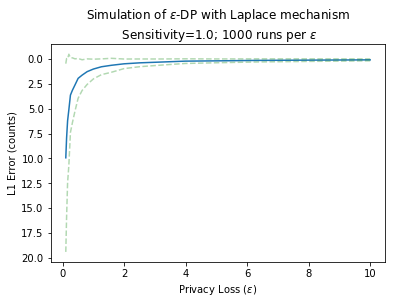

In [201]:
# First, calculate the statistics for each epsilon.
## The following is a bit of a workaround to deal with a bug in pandas: 
## https://github.com/pandas-dev/pandas/issues/10355
grouped=df.groupby('epsilon',as_index=False)
stats=grouped['L1error'].aggregate(np.mean)
stats['L1std']=grouped['L1error'].aggregate(np.std)['L1error']
print(stats)

fig,ax = plt.subplots()
# Then plot the results.
# Note that the y-axis has been inverted. This is the preferred representation at the Census Bureau.
ax.plot(stats['epsilon'],stats['L1error'])
plt.gca().invert_yaxis()
ax.set_xlabel('Privacy Loss ($\epsilon$)')
ax.set_ylabel('L1 Error (counts)')
plt.title('Simulation of $\epsilon$-DP with Laplace mechanism\n Sensitivity={}; {} runs per $\epsilon$'.format(sensitivity,numrecs))

# Uncomment the following two lines to see to +/- 1 StDev lines.
ax.plot(stats['epsilon'],stats['L1error']+stats['L1std'],'g--',alpha=0.3)
ax.plot(stats['epsilon'],stats['L1error']-stats['L1std'],'g--',alpha=0.3)

# Uncomment the following line to see the scatter plot of the indidual errors.
#ax.plot(df['epsilon'],df['L1error'],'r.',alpha=0.02,ms=1)

plt.show()